# DIMENSION REDUCTION WITH AUTOENCODERS

<font size="5">*Joe Hellerstein*, Research Scientist, eScience Institute</font>

**Motivation**

We often want to reduce the dimensionality of data
* *Data Analysis*: Focus on a few important variables
* *Dynamical Systems*: Visualize dynamics (e.g., in 2d)
* *Image Processing*: Compress data into essential pixels

Dimension reduction is crucial in machine learning for simplifying complex data sets (Van Der Maaten et al. 2009), reducing computational complexity (Ray et al. 2021), and mitigating the curse of dimensionality (Talpur et al. 2023), ultimately improving model performance and interpretability. Dimension reduction encompasses two primary approaches: feature selection (Solorio-Fernández et al. 2022), which involves choosing a subset of the most informative features from the original data-set to reduce dimensionality while maintaining interpretability; and feature extraction (Li et al. 2022), a method where new, lower-dimensional features are derived from the original data to capture essential patterns and relationships.

Autoencoders and their applications in machine learning: a survey  Kamal Berahmand1 · Fatemeh Daneshfar2 · Elaheh Sadat Salehi3 · Yuefeng Li1 · Yue Xu1, Artificial Intelligence Review (2024)

# Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
import pandas as pd
import os
from typing import Tuple

In [ ]:
DATA_DIR = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data"
NUM_TRAIN = 60000
NUM_TEST = 10000

In [ ]:
# Load and preprocess MNIST data
#(x_train, _), (x_test, _) = mnist.load_data()  # Only done if data are not local

# Helpers

In [ ]:
def saveData(arr3d, prefix="train"):
    num_arr = np.shape(arr3d)[0]
    for idx in range(num_arr):
        path = os.path.join(DATA_DIR, f"{prefix}_{idx}.csv")
        np.savetxt(path, x_train[idx,:,:], delimiter=",")

# Run it
#saveData(x_train, prefix="train")
#saveData(x_test, prefix="test")      

In [ ]:
def recoverData(prefix: str) -> np.ndarray:
    num_row = NUM_TRAIN if prefix == 'train' else NUM_TEST
    ffiles = [f for f in os.listdir(DIR) if prefix in f]
    full_arr = np.zeros((num_row, 28, 28))
    for ffile in ffiles:
        extract = ffile.split("_")[1]
        irow = int(extract.split(".")[0])
        path = os.path.join(DATA_DIR, ffile)
        arr = loaded_int = np.loadtxt(path, delimiter=',').astype(int)
        full_arr[irow] = arr
    return full_arr

# Run it
x_test_new = recoverData('test')
assert(np.shape(x_test_new)[0] == NUM_TEST)
print("OK!")

In [ ]:
def visualize(arrs: np.ndarray, num_image: int, titles: str = "", figsize=(15, 5)):
    # Displays one or more digits
    num_row = len(arrs)
    _, axes =  plt.subplots(num_row, num_image + 1, figsize=figsize)
    for irow, arr in enumerate(arrs):
        ax = axes[irow, 0]
        ax.text(0.5, 0.5, titles[irow])
        ax.axis('off')
        for i in range(num_image):
            # Original images
            #ax = plt.subplot(1, num_image + 1, i + 2)
            ax = axes[irow, i+1]
            ax.imshow(arr[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Test
visualize([x_test, x_test], 5, titles=["test1", "test2"])
#plt.close()
print("OK!")

In [ ]:
def getData():
    # Recover the data
    x_train = recoverData('train')
    x_test = recoverData('test')
    # Flatten the images (28x28 -> 784)
    x_train = x_train.reshape((len(x_train), 28 * 28))
    x_test = x_test.reshape((len(x_test), 28 * 28))
    # Normalize pixel values to [0, 1] range
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    return x_train, x_test

# Data Preparation

In [ ]:
# Recover the data
x_train = recoverData('train')
x_test = recoverData('test')
# Flatten the images (28x28 -> 784)
x_train = x_train.reshape((len(x_train), 28 * 28))
x_test = x_test.reshape((len(x_test), 28 * 28))

In [ ]:
# Look at the data in aggregate
_ = plt.hist(x_train)

In [ ]:
# Normalize pixel values to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

In [ ]:
_ = plt.hist(x_train)

# zip compression

Lossless compression achieved by clever encoding of the data

# Principal Component

* Lossy compression by extracting dominant effects
* Assumes linearity

In [ ]:
x_train, x_test = getData()

In [ ]:
def generatePCA(arr: np.ndarray, n_component: int) -> Tuple[np.ndarray, str]:
    pca = PCA(n_components=n_component, random_state=42)
    pca.fit(arr)
    x_reduced = pca.transform(arr)
    x_decoded = pca.inverse_transform(x_reduced)
    title = f"PCA/{n_component}"
    return x_decoded, title

In [ ]:
results = [generatePCA(x_test, n) for n in [28*28, 128, 64, 32, 16, 8]]
arrs = [r[0] for r in results]
titles = [r[1] for r in results]
visualize(arrs, 10, titles=titles)
    

# Deterministic Autoencoder

## What is an autoencoder?

## Implementing a deterministic autoencoder in Keras

In [ ]:
# Define autoencoder architecture
encoding_dim = 16
print(f"Compression factor is {784/encoding_dim}")

# Input layer
input_img = keras.Input(shape=(784,))

# Encoder
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create encoder model (for extracting encoded representations)
encoder = keras.Model(input_img, encoded)

# Create decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder = keras.Model(encoded_input,
                     decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Display model architecture
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,
                         epochs=15,
                         batch_size=256,
                         shuffle=True,
                         validation_data=(x_test, x_test),
                         verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate predictions
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# Visualize results
plt.subplot(1, 2, 2)
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print compression statistics
print(f"\nOriginal image size: 784 pixels")
print(f"Encoded representation size: {encoding_dim} values")
print(f"Compression ratio: {784/encoding_dim:.1f}:1")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Optional: Save the trained model
# autoencoder.save('mnist_autoencoder.h5')
# encoder.save('mnist_encoder.h5')
# decoder.save('mnist_decoder.h5')

In [ ]:
class DeterministicAutoencoder(object):

    def __init__(self, encode_dims: List[int]):

        self.image_size = image_size
        self.encoded_dim = encoded_dim
        #
        self.compression_factor = self.image_size/self.encoded_dim
        # Input layer
        input_img = keras.Input(shape=(image_size,))
        # Encoder
        encoded = None
        for idx, dim in enumerate(encode_dims[:-1):
            if idx == 0:
                encoded = layers.Dense(encode_dims[1], activation='relu')(dim)
            else:
                encoded = layers.Dense(encode_dims[idx+1], activation='relu')(encoded)
        # Decoder
        decode_dims = list(encode_dims)
        decode_dims.reverse()
        for idx, dim in enumerate(decode_dims):
            if idx == 0:
                decoded = layers.Dense(decode_dims[1], activation='relu')(encoded)
            else:
                encoded = layers.Dense(decode_dims[idx+1], activation='relu')(decoded)
        # Create the autoencoder model
        autoencoder = keras.Model(input_img, decoded)
        
        # Create encoder model (for extracting encoded representations)
        encoder = keras.Model(input_img, encoded)
        
        # Create decoder model
        encoded_input = keras.Input(shape=(encoding_dim,))
        decoder_layer1 = autoencoder.layers[-3]
        decoder_layer2 = autoencoder.layers[-2]
        decoder_layer3 = autoencoder.layers[-1]
        decoder = keras.Model(encoded_input,
                             decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))
        
        # Compile the autoencoder
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        
        # Display model architecture
        autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(x_train, x_train,
                             epochs=15,
                             batch_size=256,
                             shuffle=True,
                             validation_data=(x_test, x_test),
                             verbose=1)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Generate predictions
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = autoencoder.predict(x_test)
    
    # Visualize results
    plt.subplot(1, 2, 2)
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    
        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print compression statistics
    print(f"\nOriginal image size: 784 pixels")
    print(f"Encoded representation size: {encoding_dim} values")
    print(f"Compression ratio: {784/encoding_dim:.1f}:1")
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    # Optional: Save the trained model
    # autoencoder.save('mnist_autoencoder.h5')
    # encoder.save('mnist_encoder.h5')
    # decoder.save('mnist_decoder.h5')

## Evaluating compressions achieved

# Convolutional Autoencoder

In [ ]:
# Prepare the data
x_train, x_test = getData()
# Reshape to add channel dimension (28, 28, 1) for CNN
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

In [ ]:
# Define the Autoencoder

# Define convolutional autoencoder architecture
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

print(f"Encoded shape: {encoded.shape}")

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create encoder model (for extracting encoded representations)
encoder = keras.Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Display model architecture
autoencoder.summary()

In [ ]:

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,
                         epochs=30,
                         batch_size=128,
                         shuffle=True,
                         validation_data=(x_test, x_test),
                         verbose=1)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Generate predictions
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

print(f"Encoded representation shape: {encoded_imgs.shape}")

# Visualize some encoded feature maps
plt.subplot(1, 3, 3)
plt.imshow(encoded_imgs[0, :, :, 0], cmap='viridis')
plt.title('Encoded Feature Map (Channel 0)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Visualize original vs reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Difference (error map)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    diff = np.abs(x_test[i] - decoded_imgs[i])
    plt.imshow(diff.reshape(28, 28), cmap='hot')
    plt.title("Difference")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate reconstruction error statistics
mse = np.mean((x_test - decoded_imgs) ** 2)
mae = np.mean(np.abs(x_test - decoded_imgs))

print(f"\nReconstruction Statistics:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Analyze compression
original_size = 28 * 28 * 1  # 784 parameters per image
encoded_size = encoded_imgs.shape[1] * encoded_imgs.shape[2] * encoded_imgs.shape[3]
compression_ratio = original_size / encoded_size

print(f"\nCompression Analysis:")
print(f"Original image size: {original_size} pixels")
print(f"Encoded representation: {encoded_imgs.shape[1]}x{encoded_imgs.shape[2]}x{encoded_imgs.shape[3]} = {encoded_size} values")
print(f"Compression ratio: {compression_ratio:.1f}:1")

# Optional: Visualize learned filters from the first convolutional layer
def visualize_conv_filters(model, layer_idx=1, num_filters=16):
    """Visualize the learned convolutional filters"""
    filters = model.layers[layer_idx].get_weights()[0]

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f'Learned Filters from Layer {layer_idx}')

    for i in range(min(num_filters, 16)):
        ax = axes[i//4, i%4]
        ax.imshow(filters[:, :, 0, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize learned filters
visualize_conv_filters(autoencoder)

# Animal Images

In [4]:
stl10 = datasets.STL10(root='./data', split='train', download=True)

100.0%


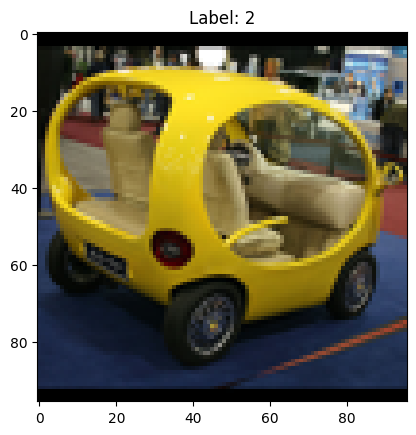

In [18]:
img, label = stl10[100]
plt.imshow(np.array(img))
plt.title(f"Label: {label}")
plt.show()

In [17]:
stl10_classes = [
    'airplane',
    'bird',
    'car',
    'cat',
    'deer',
    'dog',
    'horse',
    'monkey',
    'ship',
    'truck'
]

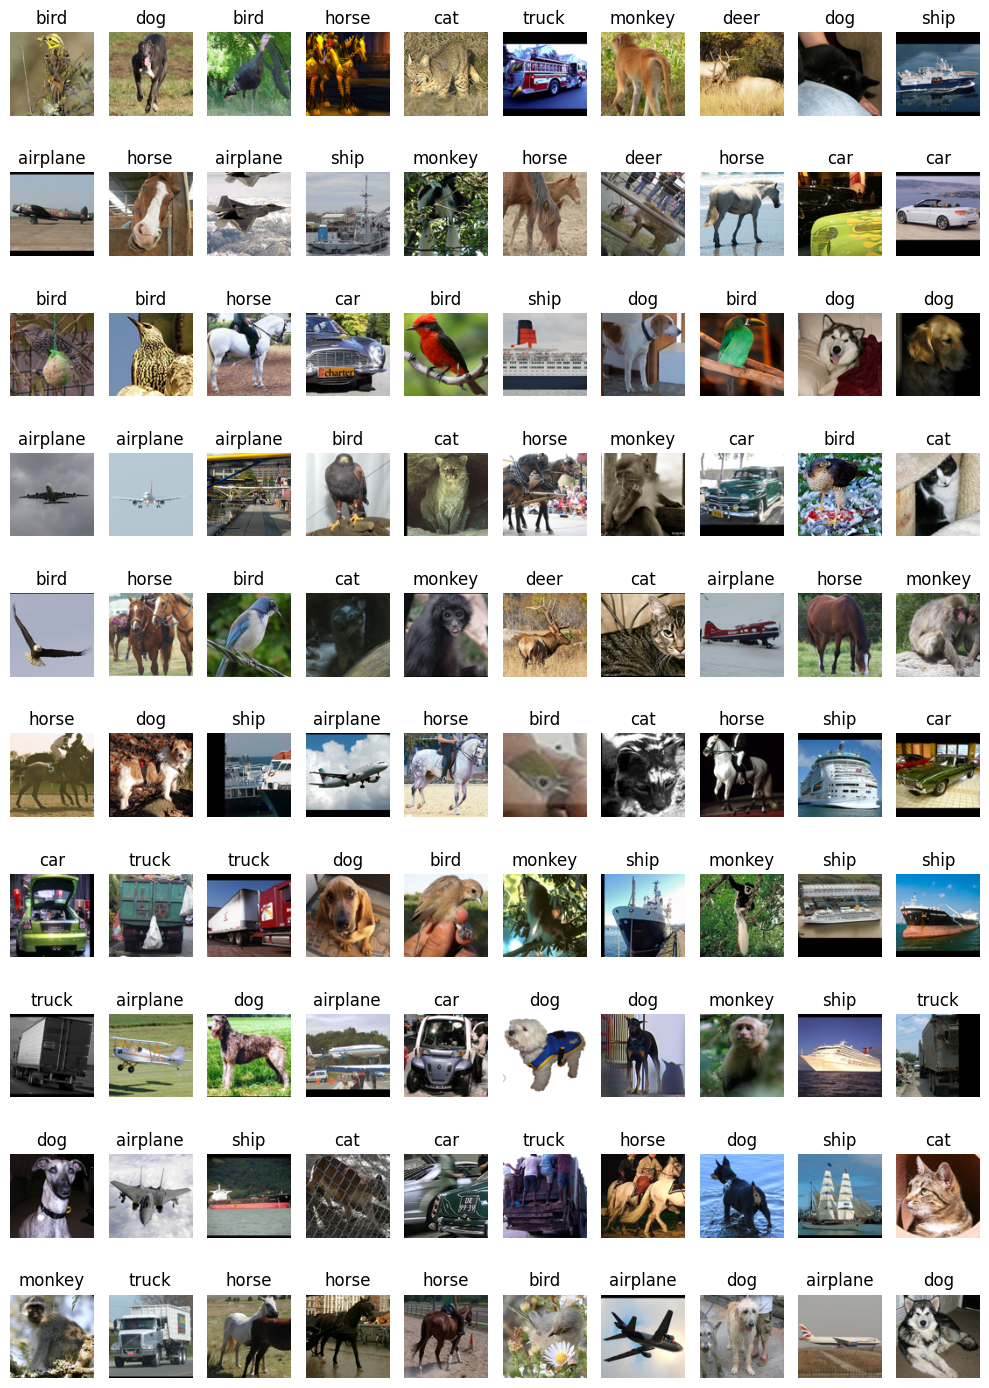

In [21]:
num_row = 10
num_col = 10
_, axes = plt.subplots(num_row, num_col, figsize=(10, 15))
for irow in range(num_row):
    for icol in range(num_col):
        idx = irow*num_col + icol
        ax = axes[irow, icol]
        img, label = stl10[idx]
        ax.imshow(np.array(img))
        name = stl10_classes[int(label)]
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
        

## Convert to grey scale

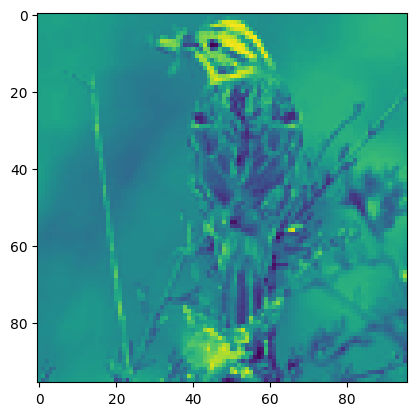

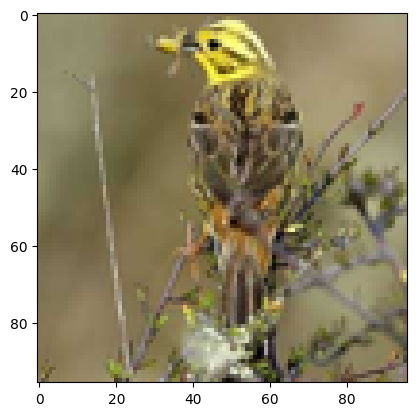

In [33]:
image, _ = stl10[0]
gray_img = image.convert('L')  
arr = np.array(gray_img)
np.shape(arr)
plt.imshow(arr)
plt.figure()
plt.imshow(np.array(image))

# Notes

In [ ]:
1. Do classification using encoded representation to reduce computation cost